In [27]:
# imprt libraries
import torch
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
from PIL import Image
from tempfile import TemporaryDirectory
import os, sys, random, time, copy
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [28]:
# Set the data folder path
data_folder = "/content/drive/MyDrive/chick_ducks"

In [29]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()
print('Using GPU: ', use_gpu)
if use_gpu == True:
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

Using GPU:  True


In [30]:
# Function to load paths from a folder
freq_print = 15
def load_paths_from_folder(data_path):
    label_names = os.listdir(data_path)
    labels = list(range(len(label_names)))
    label_dict = {label: label_names[label] for label in labels}

    file_paths = []
    for label in labels:
        i = 0
        for file in os.listdir(os.path.join(data_folder, label_dict[label])):
            file_paths.append((os.path.join(data_folder, label_dict[label], file), label))
            i += 1
            if i == 150:
                break

    random.shuffle(file_paths)

    train_num = int(0.67 * len(file_paths))
    val_num = int(0.2 * len(file_paths))

    train_list, val_list, test_list = file_paths[:train_num], file_paths[train_num:train_num + val_num], file_paths[
                                                                                                         train_num + val_num:]

    return train_list, val_list, test_list, label_dict

# Load train, validation, and test lists
train_list, val_list, test_list, label_dict = load_paths_from_folder(data_folder)

In [31]:
len(train_list), len(val_list), len(test_list)

(201, 60, 39)

In [32]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
data_transforms = {
	'train': transforms.Compose([
		transforms.RandomHorizontalFlip(),  # simple data augmentation
		transforms.RandomVerticalFlip(),	# simple data augmentation
		transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)]),

	'val': transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
}

In [33]:
# Custom dataset class
class dataloader(Dataset):
    """
    Dataset class to read image file from file path
    and return image tensor with its label_id
    """

    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __getitem__(self, index):
        file_path, label = self.file_paths[index]
        label = int(label)
        img = Image.open(file_path).convert('RGB')  # Convert to RGB
        img = img.resize((224, 224))  # Resize image

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.file_paths)

In [34]:
batch_size = 10

train_set = dataloader(train_list, transform = data_transforms['train'])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=False)

val_set = dataloader(val_list, transform = data_transforms['val'])
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
# Function to run evaluation for a model on a given dataloader object
def run_validation(model, criterion, val_loader):
	model.eval()
	pred_labels = []
	orig_labels = []

	ntotal = 0
	running_loss = 0.0
	with torch.no_grad():
		for ix, batch in enumerate(val_loader):
			inputs, targets = batch

			inputs = inputs.to(torch.float).to(device)
			targets = targets.to(torch.long).to(device)
			output = model(inputs)
			if type(output) == tuple:
				output,_ = output

			_, preds = torch.max(output.data, 1)

			loss = criterion(output, targets)
			ntotal += output.size(0)
			running_loss += loss.item() * output.size(0)

			targets = torch.squeeze(targets).data.cpu().tolist()
			orig_labels = orig_labels + targets

			preds = torch.squeeze(preds).data.cpu().tolist()
			pred_labels = pred_labels + preds

	orig_labels = np.array(orig_labels).reshape(-1,1)
	pred_labels = np.array(pred_labels).reshape(-1,1)

	val_loss = running_loss/ntotal
	val_acc = accuracy_score(orig_labels, pred_labels)
	val_f1 = f1_score(orig_labels, pred_labels, average='macro')

	return val_loss, val_acc, val_f1, orig_labels, pred_labels

In [36]:
def plot_tra_val_loss(tra_val_loss):
	epochs = list(range(1,len(tra_val_loss)+1))
	train_loss = [x[0] for x in tra_val_loss]
	val_loss = [x[1] for x in tra_val_loss]
	plt.plot(epochs, train_loss, label='Train Loss')
	plt.plot(epochs, val_loss, label='Validation Loss')
	plt.title('Training and Validation Loss per epoch')
	plt.ylabel('Loss')
	plt.xlabel('Epochs')
	plt.legend()
	plt.show()

In [37]:
def run_training(model, criterion, num_epochs, batch_size, lr, check_after, trainer = 'sgd', train_loader = train_loader, val_loader = val_loader):
	best_f1 = 0
	best_epoch = 0
	train_val_loss_epoch = []
	start_training = time.time()

	for epoch in range(num_epochs):

		### TRAINING ###
		start = time.time()

		if epoch < num_epochs//6: lr = lr
		elif epoch < num_epochs//3: lr = lr/2
		elif epoch < num_epochs//2: lr = lr/4
		elif epoch < 3*(num_epochs//4): lr = lr/10
		else: lr = lr/20

		if epoch > 2:
			for param in model.parameters():
				param.requires_grad = True


		if trainer == 'adam':
			optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
		elif trainer == 'sgd':
			optimizer = optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9, weight_decay=1e-4)
		else:
			raise Exception('Select optimiser (trainer) as adam or sgd')

		print('Epoch {}/{}'.format(epoch + 1, num_epochs))
		print('lr: {:.6f}'.format(lr))
		print('-' * 50)

		model.train()
		ntotal = 0
		running_loss = 0.0
		running_corrects = 0
		for ix, batch in enumerate(train_loader):
			inputs, targets = batch

			inputs = inputs.to(torch.float).to(device)
			targets = targets.to(torch.long).to(device)

			optimizer.zero_grad()
			output = model(inputs)
			if type(output) == tuple:
				output,_ = output

			_, preds = torch.max(output.data, 1)
			loss = criterion(output, targets)
			loss.backward()
			optimizer.step()

			ntotal += output.size(0)
			running_loss += loss.item() * output.size(0)
			running_corrects += torch.sum(preds == targets.data)

			if (ix + 1) % freq_print == 0:
				print('| Epoch:[{}][{}/{}]\tTrain_Loss: {:.4f}\tAccuracy: {:.4f}\tTime: {:.2f} mins'.format(
					epoch + 1, ix + 1, len(train_loader.dataset)//batch_size, running_loss/ntotal,
					running_corrects.item()/ntotal, (time.time() - start)/60.0))

			sys.stdout.flush()

		### VALIDATION ###
		if (epoch + 1) % check_after == 0:
			model.eval()
			start = time.time()
			val_loss, val_acc, val_f1, orig_labels, pred_labels = run_validation(model, criterion, val_loader = val_loader)
			train_val_loss_epoch.append([running_loss/ntotal, val_loss])
			print("Epoch: {}/{}\tVal_Loss: {:.4f}\tAccuracy: {:.4f}\tF1-score: {:.4f}\t{:.3f}mins".format(
					(epoch + 1), num_epochs, val_loss, val_acc, val_f1, (time.time() - start)/60.0))
			start = time.time()

			# Save model if auc best auc score is acheived (yet)
			if val_f1 > best_f1:
				print('Saving model')
				best_f1 = val_f1
				best_epoch = epoch
				best_model = copy.deepcopy(model)
				state = {
					'model': best_model,
					'auc': best_f1,
					'lr': lr,
					'saved_epoch': epoch,
				}

				save_point = os.path.join('.')
				if not os.path.isdir(os.path.join(save_point)):
					os.mkdir(save_point)

				saved_model_name = 'resnet18'
				torch.save(state, os.path.join(save_point, saved_model_name + '_' + str(round(best_f1,3)) + '_' + str(epoch) + '.t7'))

			print('=======================================================================')

	time_elapsed = time.time() - start_training
	print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
	print('Best validation F1 score: {:4f} at epoch: {}'.format(best_f1, best_epoch))

	plot_tra_val_loss(train_val_loss_epoch)
	return train_val_loss_epoch

In [38]:
model = resnet18(ResNet18_Weights.IMAGENET1K_V1)

# Locking all Parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Changing last layer of model from 1000 classes to 2 classes
num_in = model.fc.in_features
model.fc = nn.Linear(num_in, 2)

# Newly added layer has unlocked parameters
# The rest of the parameters will be unlocked after the 3rd epoch
model.eval()
model.to(device)

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Start training ... 
Epoch 1/30
lr: 0.000100
--------------------------------------------------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[1][15/20]	Train_Loss: 0.7491	Accuracy: 0.5133	Time: 0.08 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1/30	Val_Loss: 0.6090	Accuracy: 0.6667	F1-score: 0.6633	0.016mins
Saving model
Epoch 2/30
lr: 0.000100
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[2][15/20]	Train_Loss: 0.6665	Accuracy: 0.6000	Time: 0.05 mins
Epoch: 2/30	Val_Loss: 0.5241	Accuracy: 0.7667	F1-score: 0.7664	0.017mins
Saving model
Epoch 3/30
lr: 0.000100
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[3][15/20]	Train_Loss: 0.6217	Accuracy: 0.6600	Time: 0.05 mins
Epoch: 3/30	Val_Loss: 0.4990	Accuracy: 0.7833	F1-score: 0.7828	0.029mins
Saving model
Epoch 4/30
lr: 0.000100
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[4][15/20]	Train_Loss: 0.5687	Accuracy: 0.7400	Time: 0.07 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4/30	Val_Loss: 0.4096	Accuracy: 0.9000	F1-score: 0.8996	0.017mins
Saving model
Epoch 5/30
lr: 0.000100
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[5][15/20]	Train_Loss: 0.4795	Accuracy: 0.8267	Time: 0.05 mins
Epoch: 5/30	Val_Loss: 0.3418	Accuracy: 0.9500	F1-score: 0.9500	0.016mins
Saving model
Epoch 6/30
lr: 0.000050
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[6][15/20]	Train_Loss: 0.4329	Accuracy: 0.8600	Time: 0.07 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6/30	Val_Loss: 0.3157	Accuracy: 0.9500	F1-score: 0.9500	0.016mins
Saving model
Epoch 7/30
lr: 0.000025
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[7][15/20]	Train_Loss: 0.4338	Accuracy: 0.8733	Time: 0.06 mins
Epoch: 7/30	Val_Loss: 0.3121	Accuracy: 0.9667	F1-score: 0.9667	0.016mins
Saving model
Epoch 8/30
lr: 0.000013
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[8][15/20]	Train_Loss: 0.4117	Accuracy: 0.8600	Time: 0.06 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8/30	Val_Loss: 0.2990	Accuracy: 0.9167	F1-score: 0.9155	0.026mins
Epoch 9/30
lr: 0.000006
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[9][15/20]	Train_Loss: 0.4290	Accuracy: 0.8667	Time: 0.10 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9/30	Val_Loss: 0.3065	Accuracy: 0.9500	F1-score: 0.9500	0.022mins
Epoch 10/30
lr: 0.000003
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[10][15/20]	Train_Loss: 0.4418	Accuracy: 0.8400	Time: 0.06 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10/30	Val_Loss: 0.2882	Accuracy: 0.9667	F1-score: 0.9667	0.016mins
Epoch 11/30
lr: 0.000001
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[11][15/20]	Train_Loss: 0.4112	Accuracy: 0.8867	Time: 0.05 mins
Epoch: 11/30	Val_Loss: 0.2996	Accuracy: 0.9667	F1-score: 0.9666	0.028mins
Epoch 12/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[12][15/20]	Train_Loss: 0.4138	Accuracy: 0.8733	Time: 0.06 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12/30	Val_Loss: 0.3158	Accuracy: 0.8833	F1-score: 0.8825	0.017mins
Epoch 13/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[13][15/20]	Train_Loss: 0.4211	Accuracy: 0.8400	Time: 0.05 mins
Epoch: 13/30	Val_Loss: 0.2923	Accuracy: 0.9667	F1-score: 0.9667	0.017mins
Epoch 14/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[14][15/20]	Train_Loss: 0.4275	Accuracy: 0.8267	Time: 0.07 mins
Epoch: 14/30	Val_Loss: 0.2936	Accuracy: 0.9500	F1-score: 0.9500	0.024mins
Epoch 15/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[15][15/20]	Train_Loss: 0.3955	Accuracy: 0.9000	Time: 0.05 mins
Epoch: 15/30	Val_Loss: 0.3175	Accuracy: 0.9333	F1-score: 0.9333	0.017mins
Epoch 16/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[16][15/20]	Train_Loss: 0.3726	Accuracy: 0.8733	Time: 0.06 mins
Epoch: 16/30	Val_Loss: 0.2975	Accuracy: 0.9500	F1-score: 0.9500	0.016mins
Epoch 17/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[17][15/20]	Train_Loss: 0.4245	Accuracy: 0.8400	Time: 0.09 mins
Epoch: 17/30	Val_Loss: 0.2896	Accuracy: 0.9500	F1-score: 0.9500	0.017mins
Epoch 18/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[18][15/20]	Train_Loss: 0.4057	Accuracy: 0.8600	Time: 0.05 mins
Epoch: 18/30	Val_Loss: 0.3023	Accuracy: 0.9333	F1-score: 0.9333	0.016mins
Epoch 19/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[19][15/20]	Train_Loss: 0.4172	Accuracy: 0.8800	Time: 0.06 mins
Epoch: 19/30	Val_Loss: 0.3117	Accuracy: 0.9667	F1-score: 0.9666	0.025mins
Epoch 20/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[20][15/20]	Train_Loss: 0.4164	Accuracy: 0.8467	Time: 0.07 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 20/30	Val_Loss: 0.3047	Accuracy: 0.9500	F1-score: 0.9500	0.016mins
Epoch 21/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[21][15/20]	Train_Loss: 0.4420	Accuracy: 0.8267	Time: 0.06 mins
Epoch: 21/30	Val_Loss: 0.3171	Accuracy: 0.9000	F1-score: 0.8999	0.016mins
Epoch 22/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[22][15/20]	Train_Loss: 0.4166	Accuracy: 0.8600	Time: 0.07 mins
Epoch: 22/30	Val_Loss: 0.2928	Accuracy: 0.9167	F1-score: 0.9166	0.026mins
Epoch 23/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[23][15/20]	Train_Loss: 0.3759	Accuracy: 0.9267	Time: 0.06 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 23/30	Val_Loss: 0.2888	Accuracy: 0.9500	F1-score: 0.9500	0.016mins
Epoch 24/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[24][15/20]	Train_Loss: 0.3775	Accuracy: 0.9200	Time: 0.05 mins
Epoch: 24/30	Val_Loss: 0.3173	Accuracy: 0.9000	F1-score: 0.8990	0.017mins
Epoch 25/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[25][15/20]	Train_Loss: 0.4209	Accuracy: 0.8400	Time: 0.10 mins
Epoch: 25/30	Val_Loss: 0.2995	Accuracy: 0.9333	F1-score: 0.9333	0.016mins
Epoch 26/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[26][15/20]	Train_Loss: 0.4253	Accuracy: 0.8733	Time: 0.05 mins
Epoch: 26/30	Val_Loss: 0.3056	Accuracy: 0.9333	F1-score: 0.9333	0.017mins
Epoch 27/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[27][15/20]	Train_Loss: 0.3887	Accuracy: 0.9000	Time: 0.06 mins
Epoch: 27/30	Val_Loss: 0.2976	Accuracy: 0.9333	F1-score: 0.9333	0.022mins
Epoch 28/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[28][15/20]	Train_Loss: 0.4033	Accuracy: 0.8533	Time: 0.08 mins
Epoch: 28/30	Val_Loss: 0.2994	Accuracy: 0.9333	F1-score: 0.9333	0.017mins
Epoch 29/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[29][15/20]	Train_Loss: 0.3849	Accuracy: 0.9200	Time: 0.05 mins
Epoch: 29/30	Val_Loss: 0.2995	Accuracy: 0.9833	F1-score: 0.9833	0.015mins
Saving model
Epoch 30/30
lr: 0.000000
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


| Epoch:[30][15/20]	Train_Loss: 0.4309	Accuracy: 0.8400	Time: 0.05 mins


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 30/30	Val_Loss: 0.3131	Accuracy: 0.9333	F1-score: 0.9333	0.025mins
Training complete in 2m 42s
Best validation F1 score: 0.983329 at epoch: 28


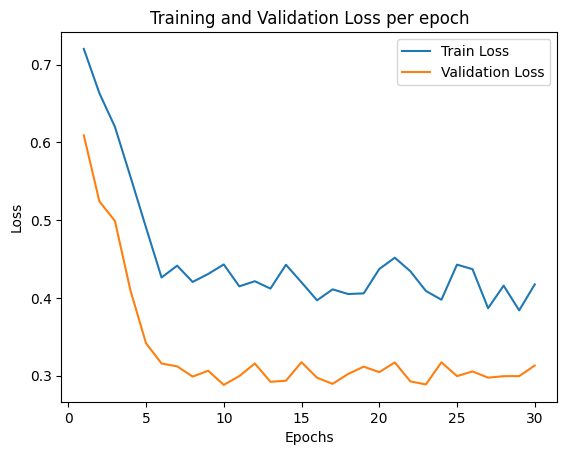

In [39]:
print('Start training ... ')
criterion = nn.CrossEntropyLoss().to(device)
train_val_loss = run_training(model=model, criterion=criterion, num_epochs=30, batch_size=batch_size, lr=1e-4,
             check_after=1, train_loader=train_loader, val_loader=val_loader)

Predicted class: duck


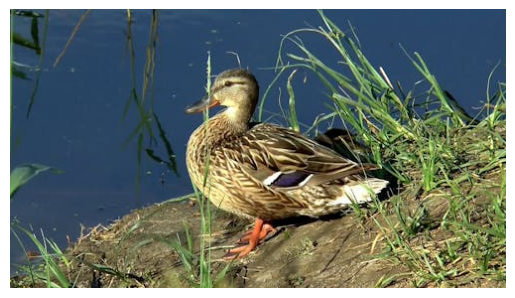

In [51]:
def classify_image(model, image_path, transform):
    """
    Classifies the given image using the provided model.

    Args:
    - model: Trained model for classification.
    - image_path: Path to the image file.
    - transform: Data transformation to be applied to the image.

    Returns:
    - predicted_class: Predicted class label (0 for chicken, 1 for duck).
    """
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))  # Resize image to match model's input size
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension

    # Move image to device (GPU if available)
    img = img.to(device)

    # Set model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        output = model(img)
        if isinstance(output, tuple):
            output, _ = output

        # Get predicted class
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

# Define the path to your random image
random_image_path = "/content/free-video-856899.jpg"

# Load the image using cv2
image_cv = cv2.imread(random_image_path)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)  # Fix the error here
# Display the image
plt.imshow(image_cv)
plt.axis("off")

# Apply the same data transformation used during training
image_transform = data_transforms['val']

# Use the classify_image function to classify the image
predicted_class = classify_image(model, random_image_path, image_transform)

# Map predicted class index to class label
class_labels = {0: 'chicken', 1: 'duck'}
predicted_label = class_labels[predicted_class]

print("Predicted class:", predicted_label)
